In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import seaborn as sns

from pydicom.pixel_data_handlers.util import apply_voi_lut

sns.set_style("whitegrid")

BASELINE_ROOT = "../../dataset/hyfusion_v2"
NPY_ROOT = os.path.join(BASELINE_ROOT, "NPY")
PNG_ROOT = os.path.join(BASELINE_ROOT, "PNG")
MANIFEST_PATH = os.path.join(BASELINE_ROOT, "manifest", "hyfusion_manifest.csv")

df = pd.read_csv(MANIFEST_PATH)
print("Total converted images:", len(df))

Total converted images: 20


In [9]:
df.head()

,split,label,src_path,png_path,site,alpha_s,alpha_final,psnr,ssim,cnr,status,pad_top,pad_bottom,pad_left,pad_right,scale_factor,scaled_h,scaled_w
0,train,TB,../../dataset/split_dataset/train/TB/dicom-stu...,../../dataset/hyfusion_v2/PNG/train/TB/dicom-s...,RS Paru dr. Ario Wirawan,0.252709,0.202709,25.235979,0.893079,0.069402,ROLLBACK,43,44,0,0,0.463768,937,1024
1,train,TB,../../dataset/split_dataset/train/TB/dicom-stu...,../../dataset/hyfusion_v2/PNG/train/TB/dicom-s...,RS Paru dr. Ario Wirawan,0.252709,0.252709,25.112305,0.861691,-0.157382,ROLLBACK,0,0,71,72,0.424192,1024,881
2,train,TB,../../dataset/split_dataset/train/TB/dicom-stu...,../../dataset/hyfusion_v2/PNG/train/TB/dicom-s...,RS Paru dr. Ario Wirawan,0.252709,0.252709,25.077250,0.886889,-0.137124,ROLLBACK,0,0,14,14,0.502207,1024,996
3,train,TB,../../dataset/split_dataset/train/TB/dicom-stu...,../../dataset/hyfusion_v2/PNG/train/TB/dicom-s...,RS Paru dr. Ario Wirawan,0.252709,0.052709,25.751079,0.864873,0.068358,ROLLBACK,0,0,69,69,0.485769,1024,886
4,train,TB,../../dataset/split_dataset/train/TB/pacs_rslt...,../../dataset/hyfusion_v2/PNG/train/TB/pacs_rs...,RS Paru dr. Ario Wirawan,0.252709,0.252709,20.060268,0.824884,-0.422673,ROLLBACK,0,0,90,91,0.361072,1024,843


In [10]:
df.tail()

,split,label,src_path,png_path,site,alpha_s,alpha_final,psnr,ssim,cnr,status,pad_top,pad_bottom,pad_left,pad_right,scale_factor,scaled_h,scaled_w
15,val,NonTB,../../dataset/split_dataset/val/NonTB/pacs_rsl...,../../dataset/hyfusion_v2/PNG/val/NonTB/pacs_r...,RS Paru dr. Ario Wirawan,0.252709,0.252709,15.945354,0.850086,-0.758863,ROLLBACK,0,0,90,91,0.361072,1024,843
16,test,TB,../../dataset/split_dataset/test/TB/pacs_rslt-...,../../dataset/hyfusion_v2/PNG/test/TB/pacs_rsl...,RS Paru dr. Ario Wirawan,0.252709,0.252709,25.400670,0.891455,-0.071000,ROLLBACK,0,0,90,91,0.361072,1024,843
17,test,TB,../../dataset/split_dataset/test/TB/dicom-stud...,../../dataset/hyfusion_v2/PNG/test/TB/dicom-st...,RS Paru dr. Ario Wirawan,0.252709,0.252709,24.037389,0.858637,-0.224082,ROLLBACK,12,12,0,0,0.450704,1000,1024
18,test,NonTB,../../dataset/split_dataset/test/NonTB/Pacs-di...,../../dataset/hyfusion_v2/PNG/test/NonTB/Pacs-...,RS Paru dr. Ario Wirawan,0.252709,0.252709,13.615465,0.775694,-1.055515,ROLLBACK,0,0,90,91,0.361072,1024,843
19,test,NonTB,../../dataset/split_dataset/test/NonTB/pacs_rs...,../../dataset/hyfusion_v2/PNG/test/NonTB/pacs_...,RS Paru dr. Ario Wirawan,0.252709,0.252709,15.314615,0.878076,-0.823670,ROLLBACK,0,0,90,91,0.361072,1024,843


In [11]:
for split in ["train", "val", "test"]:
    X_path = os.path.join(NPY_ROOT, f"X_{split}.npy")
    y_path = os.path.join(NPY_ROOT, f"y_{split}.npy")

    if not os.path.exists(X_path):
        print(f"[WARN] {X_path} not found")
        continue

    X = np.load(X_path)
    y = np.load(y_path)

    print(f"{split.upper():5s} | X.shape={X.shape}, y.shape={y.shape}")

TRAIN | X.shape=(12, 1024, 1024, 1), y.shape=(12,)
VAL   | X.shape=(4, 1024, 1024, 1), y.shape=(4,)
TEST  | X.shape=(4, 1024, 1024, 1), y.shape=(4,)


In [12]:
from pydicom.pixel_data_handlers.util import apply_voi_lut

def load_raw_dicom(dcm_path):
    ds = pydicom.dcmread(dcm_path)
    img = ds.pixel_array.astype(np.float32)

    try:
        img = apply_voi_lut(img, ds)
    except Exception:
        pass

    mn, mx = img.min(), img.max()
    if mx > mn:
        img = (img - mn) / (mx - mn)

    return img


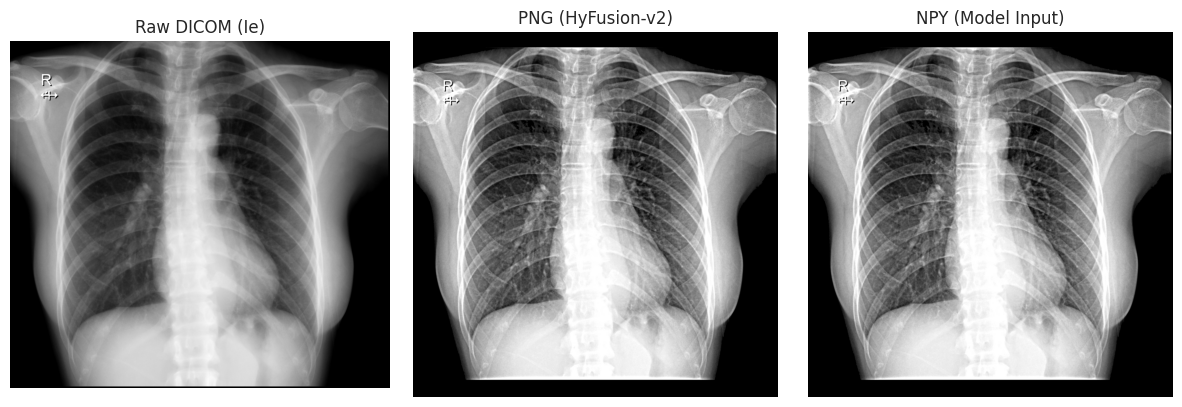

In [15]:
sample = df.sample(1).iloc[0]

raw = load_raw_dicom(sample["src_path"])
png = cv2.imread(sample["png_path"], cv2.IMREAD_GRAYSCALE)
split = sample["split"]
df_split = df[df["split"] == split].reset_index(drop=True)
idx = df_split.index[df_split["src_path"] == sample["src_path"]][0]
X = np.load(os.path.join(NPY_ROOT, f"X_{split}.npy"))
npy = X[idx, :, :, 0]

# ---- VISUALIZE ----
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(raw, cmap="gray")
ax[0].set_title("Raw DICOM (Ie)")
ax[1].imshow(png, cmap="gray")
ax[1].set_title("PNG (HyFusion-v2)")
ax[2].imshow(npy, cmap="gray")
ax[2].set_title("NPY (Model Input)")
for a in ax:
    a.axis("off")

plt.tight_layout()
plt.show()


In [16]:
pad_cols = ["pad_top", "pad_bottom", "pad_left", "pad_right"]
df[pad_cols].describe()

,pad_top,pad_bottom,pad_left,pad_right
count,20.000000,20.000000,20.000000,20.000000
mean,2.750000,2.800000,74.400000,75.150000
std,9.845517,10.060867,32.128689,32.426881
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,70.500000,71.250000
50%,0.000000,0.000000,90.000000,91.000000
75%,0.000000,0.000000,90.000000,91.000000
max,43.000000,44.000000,108.000000,108.000000


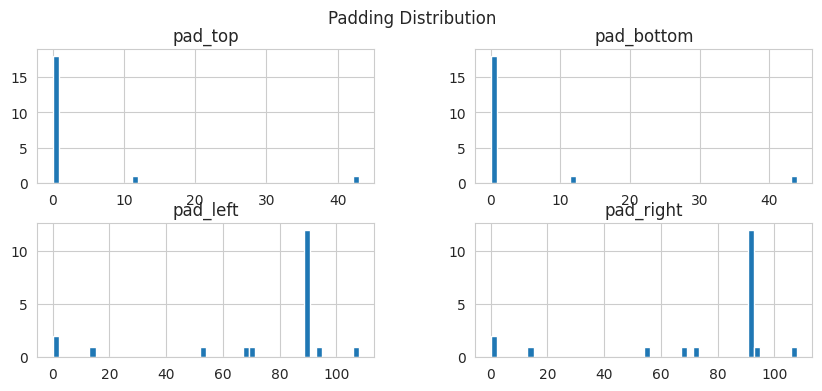

In [17]:
df[pad_cols].hist(bins=50, figsize=(10,4))
plt.suptitle("Padding Distribution")
plt.show()


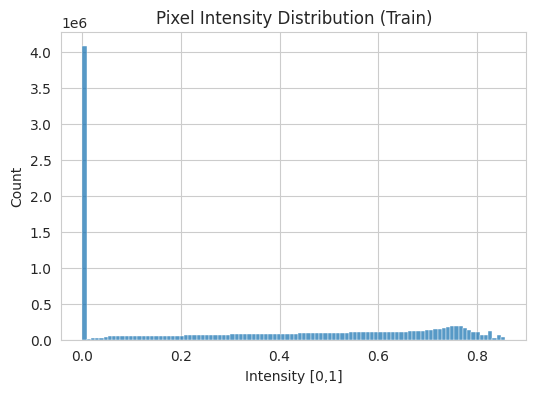

In [21]:
X_train = np.load(os.path.join(NPY_ROOT,"X_train.npy"))

plt.figure(figsize=(6,4))
sns.histplot(X_train.flatten(), bins=100)
plt.title("Pixel Intensity Distribution (Train)")
plt.xlabel("Intensity [0,1]")
plt.show()


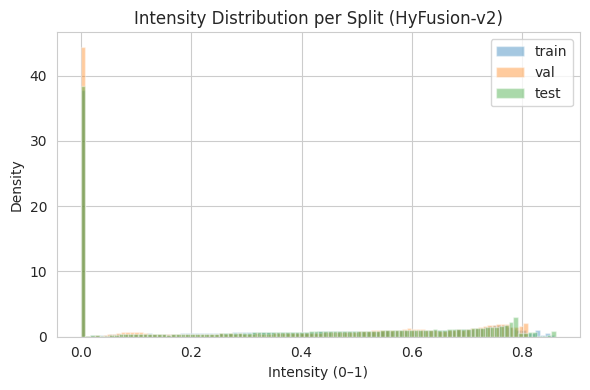

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

MAX_PIXELS = 500_000  # batas aman utk EDA

for split in ["train", "val", "test"]:
    X = np.load(os.path.join(NPY_ROOT, f"X_{split}.npy"))

    # flatten tapi sampling agar ringan
    pixels = X.reshape(-1)
    if len(pixels) > MAX_PIXELS:
        pixels = np.random.choice(pixels, MAX_PIXELS, replace=False)

    plt.hist(
        pixels,
        bins=100,
        alpha=0.4,
        density=True,
        label=split
    )

plt.legend()
plt.title("Intensity Distribution per Split (HyFusion-v2)")
plt.xlabel("Intensity (0–1)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


In [23]:
png_norm = png.astype(np.float32) / 255.0
diff = np.abs(png_norm - npy)

print("Max absolute difference PNG vs NPY:", diff.max())


Max absolute difference PNG vs NPY: 0.0039215386


In [24]:
df.groupby(["split", "label"]).size()


split  label
test   NonTB    2
       TB       2
train  NonTB    7
       TB       5
val    NonTB    2
       TB       2
dtype: int64

In [27]:
print("===== EDA CONVERSION SUMMARY =====")
print("Total images:", len(df))
print("\nSplit × Label:")
print(df.groupby(["split", "label"]).size())

===== EDA CONVERSION SUMMARY =====
Total images: 20

Split × Label:
split  label
test   NonTB    2
       TB       2
train  NonTB    7
       TB       5
val    NonTB    2
       TB       2
dtype: int64
